In [1]:
import sys
import os
import pathlib
import json
import pyvista as pv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


working_dir = pathlib.Path(os.path.abspath(""))
sys.path.append(str(working_dir.parents[1]))
from runs import find_runs  # noqa: E402

In [2]:
location_error = pd.DataFrame()
velocity_error = pd.DataFrame()
velocity_error_relative = pd.DataFrame()

# Iterate over all runs
for run_path in find_runs(working_dir.parent):
    # Read parameters.json
    with open(run_path / "parameters.json") as file:
        parameters = json.load(file)

    # Calculate mean L2 error norm for each timestep
    location_error_data = []
    velocity_error_data = []
    velocity_error_relative_data = []
    indices = []
    for timestep_path in (run_path / "solution").glob("*_particles_*.pvtu"):
        mesh = pv.read(timestep_path)

        # Calculate error norm for each particle
        mesh["location_error"] = np.linalg.norm(
            mesh.points - mesh["analytical_location"], axis=1
        )

        # For the velocity, we calculate the relative error
        mesh["velocity_error"] = np.linalg.norm(
            mesh["velocity"] - mesh["analytical_velocity"], axis=1
        )
        mesh["velocity_error_relative"] = mesh["velocity_error"] / np.linalg.norm(
            mesh["analytical_velocity"], axis=1
        )

        # Calculate median error norm over all particles
        location_error_data.append(np.median(mesh["location_error"]))
        velocity_error_data.append(np.median(mesh["velocity_error"]))
        velocity_error_relative_data.append(np.median(mesh["velocity_error_relative"]))

        # Use the timestep number from the filename as index
        indices.append(int(timestep_path.stem.split("_")[-1]))

    # Generate descriptive column name
    column_name = {
        "nearest-neighbor": "NN",
        "rbf-pum-direct": "RBF",
    }[parameters["mapping"]]

    if parameters["mapping"] == "rbf-pum-direct":
        column_name += (
            "_"
            + {
                "compact-polynomial-c0": "CP0",
                "compact-polynomial-c2": "CP2",
                "compact-polynomial-c4": "CP4",
                "compact-polynomial-c6": "CP6",
                "compact-polynomial-c8": "CP8",
            }[parameters["basis_function"]]
        )

        column_name += f"_{parameters['support_radius']}"

    column_name += f"_{parameters['refinement']}"

    # Insert into DataFrame
    location_error[column_name] = pd.Series(data=location_error_data, index=indices)
    velocity_error[column_name] = pd.Series(data=velocity_error_data, index=indices)
    velocity_error_relative[column_name] = pd.Series(
        data=velocity_error_relative_data, index=indices
    )

In [3]:
# Sort columns by name
location_error.sort_index(inplace=True, axis=1)
velocity_error.sort_index(inplace=True, axis=1)
velocity_error_relative.sort_index(inplace=True, axis=1)

# Sort rows by timestep number
location_error.sort_index(inplace=True, axis=0)
velocity_error.sort_index(inplace=True, axis=0)
velocity_error_relative.sort_index(inplace=True, axis=0)

In [4]:
velocity_error.filter(like="NN", axis=1).describe()

,NN_0,NN_1,NN_2,NN_3,NN_4,NN_5,NN_6,NN_7,NN_8,NN_9
count,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000
mean,0.582040,0.582040,0.204693,0.106534,0.048424,0.025759,0.015419,0.010444,0.008633,0.008230
std,0.282464,0.282464,0.091970,0.072295,0.066414,0.065639,0.065814,0.066022,0.066125,0.066151
min,0.001431,0.001431,0.001431,0.001431,0.001431,0.001431,0.001431,0.001431,0.001431,0.001431
25%,0.347115,0.347115,0.163906,0.077431,0.028665,0.013053,0.006418,0.003363,0.002197,0.001720
50%,0.650294,0.650294,0.234827,0.119130,0.049652,0.023330,0.011785,0.006117,0.003921,0.003364
75%,0.852452,0.852452,0.254992,0.131904,0.061379,0.029595,0.015123,0.008047,0.005724,0.005221
max,0.941412,0.941412,0.941085,0.941085,0.941085,0.941085,0.941085,0.941085,0.941085,0.941085


In [5]:
velocity_error.filter(like="RBF_CP4", axis=1).describe()

,RBF_CP4_0.5_0,RBF_CP4_0.5_1,RBF_CP4_0.5_2,RBF_CP4_0.5_3,RBF_CP4_0.5_4,RBF_CP4_0.5_5,RBF_CP4_0.5_6,RBF_CP4_0.5_7,RBF_CP4_0.5_8,RBF_CP4_0.5_9
count,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000
mean,0.582040,0.582040,0.165458,0.015987,0.008344,0.008478,0.008482,0.008482,0.008482,0.008482
std,0.282464,0.282464,0.080901,0.065712,0.066149,0.066141,0.066141,0.066141,0.066141,0.066141
min,0.001431,0.001431,0.001431,0.001431,0.001400,0.001413,0.001414,0.001414,0.001414,0.001414
25%,0.347115,0.347115,0.131443,0.010069,0.001632,0.001645,0.001653,0.001650,0.001650,0.001650
50%,0.650294,0.650294,0.164814,0.012621,0.003251,0.003408,0.003408,0.003413,0.003413,0.003413
75%,0.852452,0.852452,0.210558,0.013782,0.005529,0.005720,0.005703,0.005707,0.005707,0.005707
max,0.941412,0.941412,0.941085,0.941085,0.941085,0.941085,0.941085,0.941085,0.941085,0.941085


In [6]:
velocity_error.filter(like="RBF_CP8", axis=1).describe()

,RBF_CP8_0.5_0,RBF_CP8_0.5_1,RBF_CP8_0.5_2,RBF_CP8_0.5_3,RBF_CP8_0.5_4,RBF_CP8_0.5_5,RBF_CP8_0.5_6,RBF_CP8_0.5_7,RBF_CP8_0.5_8
count,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000
mean,0.582040,0.582040,0.322257,0.018688,0.008367,0.008482,0.008482,0.008482,0.008482
std,0.282464,0.282464,0.125087,0.065599,0.066148,0.066141,0.066141,0.066141,0.066141
min,0.001431,0.001431,0.001431,0.001431,0.001403,0.001414,0.001415,0.001414,0.001414
25%,0.347115,0.347115,0.250552,0.012234,0.001633,0.001649,0.001650,0.001650,0.001650
50%,0.650294,0.650294,0.346921,0.015680,0.003281,0.003408,0.003413,0.003413,0.003413
75%,0.852452,0.852452,0.390390,0.017392,0.005549,0.005704,0.005708,0.005707,0.005707
max,0.941412,0.941412,0.941085,0.941085,0.941085,0.941085,0.941085,0.941085,0.941085


array([<Axes: xlabel='timestep'>, <Axes: xlabel='timestep'>,
       <Axes: xlabel='timestep'>], dtype=object)

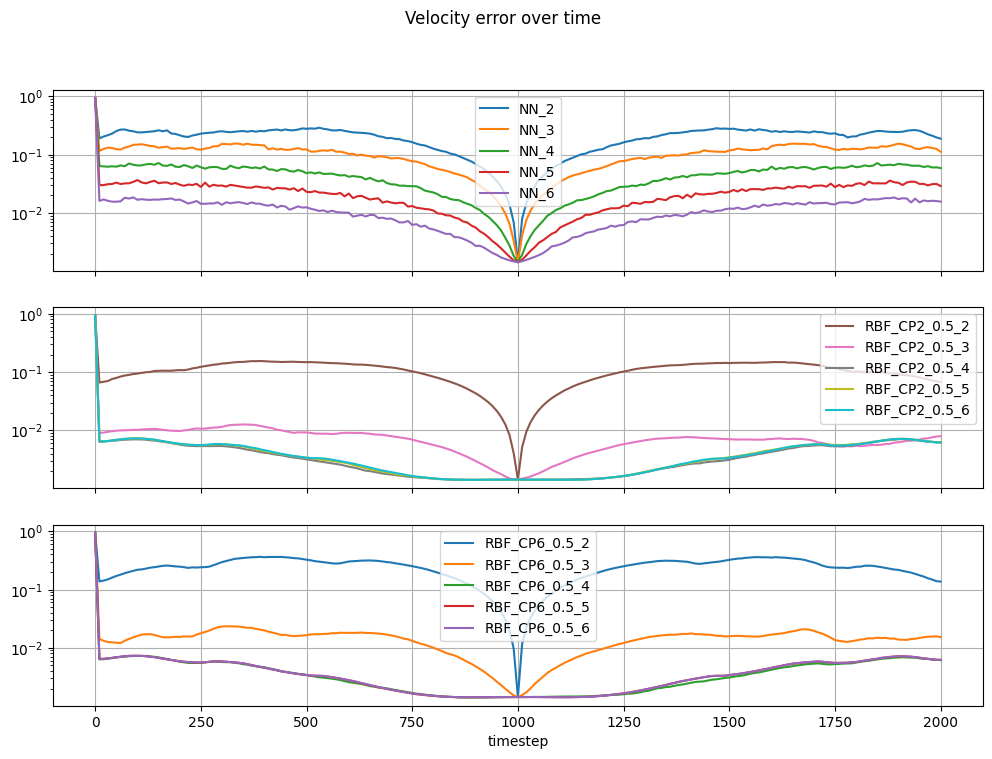

In [7]:
velocity_error.filter(
    axis=1,
    items=[
        "NN_2",
        "NN_3",
        "NN_4",
        "NN_5",
        "NN_6",
        "RBF_CP2_0.5_2",
        "RBF_CP2_0.5_3",
        "RBF_CP2_0.5_4",
        "RBF_CP2_0.5_5",
        "RBF_CP2_0.5_6",
        "RBF_CP6_0.5_2",
        "RBF_CP6_0.5_3",
        "RBF_CP6_0.5_4",
        "RBF_CP6_0.5_5",
        "RBF_CP6_0.5_6",
    ],
).plot(
    title="Velocity error over time",
    figsize=(12, 8),
    grid=True,
    xlabel="timestep",
    logy=True,
    sharey=True,
    subplots=[
        (
            "NN_2",
            "NN_3",
            "NN_4",
            "NN_5",
            "NN_6",
        ),
        (
            "RBF_CP2_0.5_2",
            "RBF_CP2_0.5_3",
            "RBF_CP2_0.5_4",
            "RBF_CP2_0.5_5",
            "RBF_CP2_0.5_6",
        ),
        (
            "RBF_CP6_0.5_2",
            "RBF_CP6_0.5_3",
            "RBF_CP6_0.5_4",
            "RBF_CP6_0.5_5",
            "RBF_CP6_0.5_6",
        ),
    ],
)

In [8]:
velocity_error

,NN_0,NN_1,NN_2,NN_3,NN_4,NN_5,NN_6,NN_7,NN_8,NN_9,...,RBF_CP6_0.5_9,RBF_CP8_0.5_0,RBF_CP8_0.5_1,RBF_CP8_0.5_2,RBF_CP8_0.5_3,RBF_CP8_0.5_4,RBF_CP8_0.5_5,RBF_CP8_0.5_6,RBF_CP8_0.5_7,RBF_CP8_0.5_8
0,0.941085,0.941085,0.941085,0.941085,0.941085,0.941085,0.941085,0.941085,0.941085,0.941085,...,0.941085,0.941085,0.941085,0.941085,0.941085,0.941085,0.941085,0.941085,0.941085,0.941085
10,0.941412,0.941412,0.190468,0.115842,0.063817,0.029996,0.016108,0.008281,0.006628,0.005622,...,0.006454,0.941412,0.941412,0.180758,0.013632,0.006292,0.006452,0.006454,0.006454,0.006454
20,0.935865,0.935865,0.205059,0.125758,0.062903,0.030046,0.017021,0.009161,0.006300,0.006162,...,0.006471,0.935865,0.935865,0.184824,0.012777,0.006285,0.006466,0.006471,0.006471,0.006471
30,0.928228,0.928228,0.216206,0.131914,0.062305,0.031150,0.016174,0.008858,0.006222,0.005935,...,0.006563,0.928228,0.928228,0.198285,0.012300,0.006496,0.006570,0.006563,0.006563,0.006563
40,0.920206,0.920206,0.230118,0.129900,0.063215,0.031410,0.015603,0.008567,0.006234,0.006290,...,0.006703,0.920206,0.920206,0.215251,0.012234,0.006643,0.006700,0.006703,0.006703,0.006703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1960,0.919566,0.919566,0.241141,0.131779,0.061435,0.031542,0.016380,0.009026,0.006077,0.006020,...,0.006598,0.919566,0.919566,0.217515,0.014697,0.006450,0.006603,0.006599,0.006598,0.006598
1970,0.924222,0.924222,0.223596,0.134652,0.063586,0.029769,0.015932,0.008709,0.006013,0.005654,...,0.006425,0.924222,0.924222,0.207232,0.015209,0.006375,0.006433,0.006426,0.006425,0.006425
1980,0.930205,0.930205,0.211992,0.130523,0.060313,0.031209,0.016176,0.009007,0.006358,0.005594,...,0.006310,0.930205,0.930205,0.196736,0.015385,0.006288,0.006323,0.006311,0.006310,0.006310
1990,0.936061,0.936061,0.197752,0.125684,0.060717,0.031491,0.016020,0.007900,0.006058,0.005426,...,0.006200,0.936061,0.936061,0.185924,0.015238,0.006199,0.006195,0.006199,0.006200,0.006200


(0.001, 1.0)

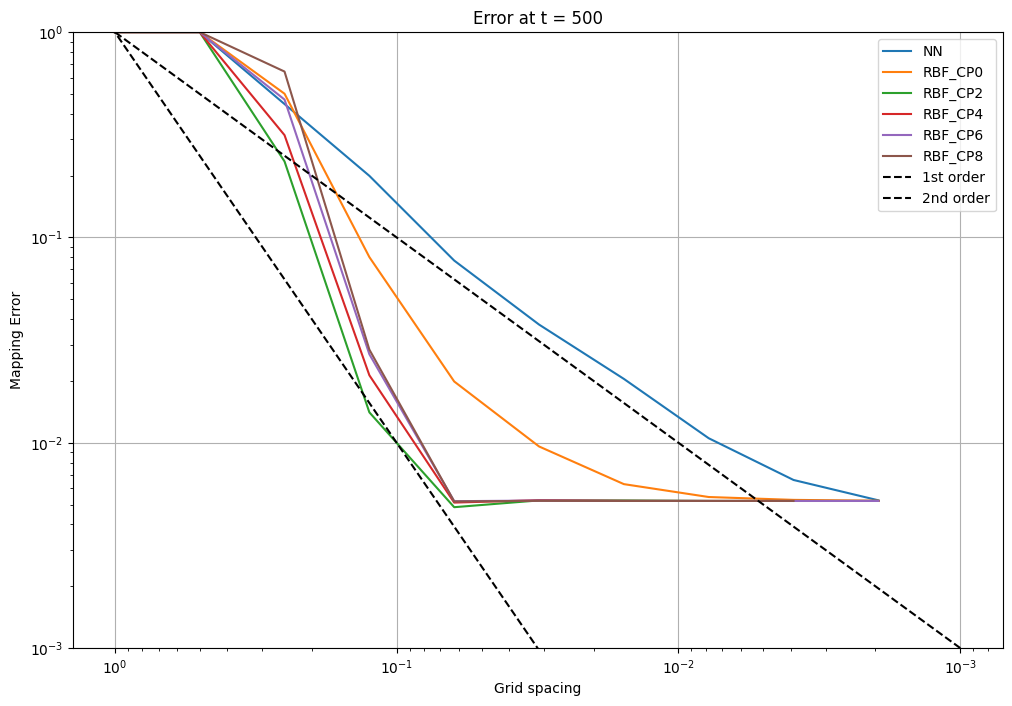

In [12]:
fig, ax = plt.subplots(figsize=(12, 8))

t = 500
velocity_error_T = velocity_error_relative.T.loc[:, t]

velocity_error_T.filter(axis=0, like="NN").rename(index=lambda x: 1/(2 ** int(x.split("_")[-1]))).plot(ax=ax, label="NN")
velocity_error_T.filter(axis=0, like="RBF_CP0").rename(index=lambda x: 1/(2 ** int(x.split("_")[-1]))).plot(ax=ax, label="RBF_CP0")
velocity_error_T.filter(axis=0, like="RBF_CP2").rename(index=lambda x: 1/(2 ** int(x.split("_")[-1]))).plot(ax=ax, label="RBF_CP2")
velocity_error_T.filter(axis=0, like="RBF_CP4").rename(index=lambda x: 1/(2 ** int(x.split("_")[-1]))).plot(ax=ax, label="RBF_CP4")
velocity_error_T.filter(axis=0, like="RBF_CP6").rename(index=lambda x: 1/(2 ** int(x.split("_")[-1]))).plot(ax=ax, label="RBF_CP6")
velocity_error_T.filter(axis=0, like="RBF_CP8").rename(index=lambda x: 1/(2 ** int(x.split("_")[-1]))).plot(ax=ax, label="RBF_CP8")

# Add reference line for 1st order
grid_spacing = np.logspace(-3, 0, 100, base=10)
reference_line_1st = grid_spacing ** 1  # 1st order
ax.plot(grid_spacing, reference_line_1st, 'k--', label="1st order")

# Add reference line for 2nd order
reference_line_2nd = grid_spacing ** 2  # 2nd order
ax.plot(grid_spacing, reference_line_2nd, 'k--', label="2nd order")

ax.set_title(f"Error at t = {t}")
ax.legend()
ax.grid()
ax.set_xlabel("Grid spacing")
ax.invert_xaxis()
ax.set_ylabel("Mapping Error")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim([1e-3, 1e0])